# Step 1

### Target
- Get the set-up right
- Set the data transforms (Train and Test)
- Set data loader (after obtaining train / test data)
- Get the basic skeleton right (initial working model architecture)
- Set basic working code for training & test loop
- Batch Normalization and ReLU activation incorporated

### Result
- Parameters: 12,090
- Best Training Accuracy: 99.24% (14th Epoch)
- Best Test Accuracy: 99.01% (10th Epoch)

### Analysis
- Number of model parameters (12K) is > than the required number (of 8K)
- Good model, The gap between training and test accuracy is less (Epochs 3 to 8)
- Model is overfitting slighly after the 9th epoch

### Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

### Perform Data Transformations

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                   # transforms.Resize((28, 28)),
                   # transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                   transforms.ToTensor(),
                   transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                   # Note the difference between (0.1307) and (0.1307,)
                   ])

# Test Phase transformations
test_transforms = transforms.Compose([
                   # transforms.Resize((28, 28)),
                   # transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                   transforms.ToTensor(),
                   transforms.Normalize((0.1307,), (0.3081,))
                   ])


### Download Dataset and Create Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

### Initialize Dataloader Arguments & Test/Train Dataloaders

In [4]:
SEED = 6
BATCH_SIZE = 128
CUDA_BATCH_SIZE = 64

# Use CUDA if available
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# Dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=CUDA_BATCH_SIZE)

# Train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# Test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


### Data Statistics

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)


D:\Software\Anaconda3\envs\pytorch25\Lib\site-packages\torchvision\datasets\mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


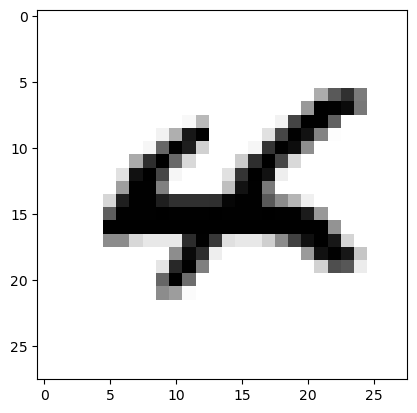

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

### Some data visualization

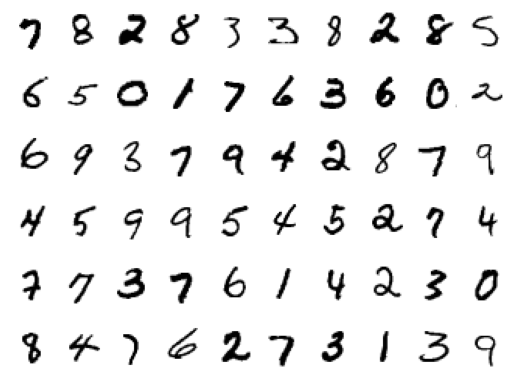

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

### How did we get those mean and std values which we used above?

In [7]:
# simple transform
simple_transforms = transforms.Compose([
                    # transforms.Resize((28, 28)),
                    # transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                    transforms.ToTensor(),
                    # transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                    # Note the difference between (0.1307) and (0.1307,)
                    ])

exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


D:\Software\Anaconda3\envs\pytorch25\Lib\site-packages\torchvision\datasets\mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


### The Model and its parameters

In [8]:
# This notebook experiment uses Net1() model in Models.py
from Models import get_model1, save_model

### Model Summary

In [9]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = get_model1().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
       BatchNorm2d-2           [-1, 16, 26, 26]              32
            Conv2d-3           [-1, 16, 24, 24]           2,320
       BatchNorm2d-4           [-1, 16, 24, 24]              32
            Conv2d-5           [-1, 16, 22, 22]           2,320
       BatchNorm2d-6           [-1, 16, 22, 22]              32
            Conv2d-7           [-1, 16, 20, 20]           2,320
       BatchNorm2d-8           [-1, 16, 20, 20]              32
            Conv2d-9           [-1, 16, 18, 18]           2,320
      BatchNorm2d-10           [-1, 16, 18, 18]              32
           Conv2d-11           [-1, 16, 16, 16]           2,320
           Conv2d-12           [-1, 10, 16, 16]             170
AdaptiveAvgPool2d-13             [-1, 10, 1, 1]               0
Total params: 12,090
Trainable par

### Define the functions for Training and Testing

In [10]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # Get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Training: Batch_id={batch_idx} Loss={loss.item()} Accuracy={100 * correct / processed:0.2f}')
    train_acc.append(100 * correct / processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

### Let's Train and test our model

In [11]:
model =  get_model1().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Training: Batch_id=468 Loss=0.09943994879722595 Accuracy=83.63: 100%|████████████████| 469/469 [00:09<00:00, 49.98it/s]


Test set: Average loss: 0.1376, Accuracy: 9609/10000 (96.09%)

EPOCH: 1


Training: Batch_id=468 Loss=0.06878383457660675 Accuracy=97.01: 100%|████████████████| 469/469 [00:09<00:00, 50.24it/s]


Test set: Average loss: 0.0752, Accuracy: 9769/10000 (97.69%)

EPOCH: 2


Training: Batch_id=468 Loss=0.04609218239784241 Accuracy=97.94: 100%|████████████████| 469/469 [00:09<00:00, 50.10it/s]


Test set: Average loss: 0.0567, Accuracy: 9837/10000 (98.37%)

EPOCH: 3


Training: Batch_id=468 Loss=0.11561069637537003 Accuracy=98.25: 100%|████████████████| 469/469 [00:09<00:00, 49.70it/s]


Test set: Average loss: 0.0545, Accuracy: 9836/10000 (98.36%)

EPOCH: 4


Training: Batch_id=468 Loss=0.014103717170655727 Accuracy=98.41: 100%|███████████████| 469/469 [00:09<00:00, 49.22it/s]


Test set: Average loss: 0.0476, Accuracy: 9854/10000 (98.54%)

EPOCH: 5


Training: Batch_id=468 Loss=0.004382284823805094 Accuracy=98.63: 100%|███████████████| 469/469 [00:09<00:00, 50.04it/s]


Test set: Average loss: 0.0462, Accuracy: 9852/10000 (98.52%)

EPOCH: 6


Training: Batch_id=468 Loss=0.028027629479765892 Accuracy=98.72: 100%|███████████████| 469/469 [00:09<00:00, 49.53it/s]


Test set: Average loss: 0.0550, Accuracy: 9839/10000 (98.39%)

EPOCH: 7


Training: Batch_id=468 Loss=0.07375866919755936 Accuracy=98.76: 100%|████████████████| 469/469 [00:09<00:00, 50.50it/s]


Test set: Average loss: 0.0486, Accuracy: 9858/10000 (98.58%)

EPOCH: 8


Training: Batch_id=468 Loss=0.0933104157447815 Accuracy=98.91: 100%|█████████████████| 469/469 [00:09<00:00, 51.02it/s]


Test set: Average loss: 0.0381, Accuracy: 9886/10000 (98.86%)

EPOCH: 9


Training: Batch_id=468 Loss=0.02264176867902279 Accuracy=99.04: 100%|████████████████| 469/469 [00:09<00:00, 51.04it/s]


Test set: Average loss: 0.0378, Accuracy: 9893/10000 (98.93%)

EPOCH: 10


Training: Batch_id=468 Loss=0.05906904116272926 Accuracy=99.08: 100%|████████████████| 469/469 [00:09<00:00, 50.57it/s]


Test set: Average loss: 0.0328, Accuracy: 9901/10000 (99.01%)

EPOCH: 11


Training: Batch_id=468 Loss=0.06189534440636635 Accuracy=99.12: 100%|████████████████| 469/469 [00:09<00:00, 49.61it/s]


Test set: Average loss: 0.0343, Accuracy: 9889/10000 (98.89%)

EPOCH: 12


Training: Batch_id=468 Loss=0.06024720147252083 Accuracy=99.17: 100%|████████████████| 469/469 [00:09<00:00, 50.78it/s]


Test set: Average loss: 0.0387, Accuracy: 9874/10000 (98.74%)

EPOCH: 13


Training: Batch_id=468 Loss=0.045265067368745804 Accuracy=99.23: 100%|███████████████| 469/469 [00:09<00:00, 50.03it/s]


Test set: Average loss: 0.0415, Accuracy: 9876/10000 (98.76%)

EPOCH: 14


Training: Batch_id=468 Loss=0.027115346863865852 Accuracy=99.24: 100%|███████████████| 469/469 [00:09<00:00, 51.44it/s]


Test set: Average loss: 0.0393, Accuracy: 9876/10000 (98.76%)



### Plot the Training and Tests - Accuracy and losses

In [12]:
t = [t_items.item() for t_items in train_losses]

Text(0.5, 1.0, 'Test Accuracy')

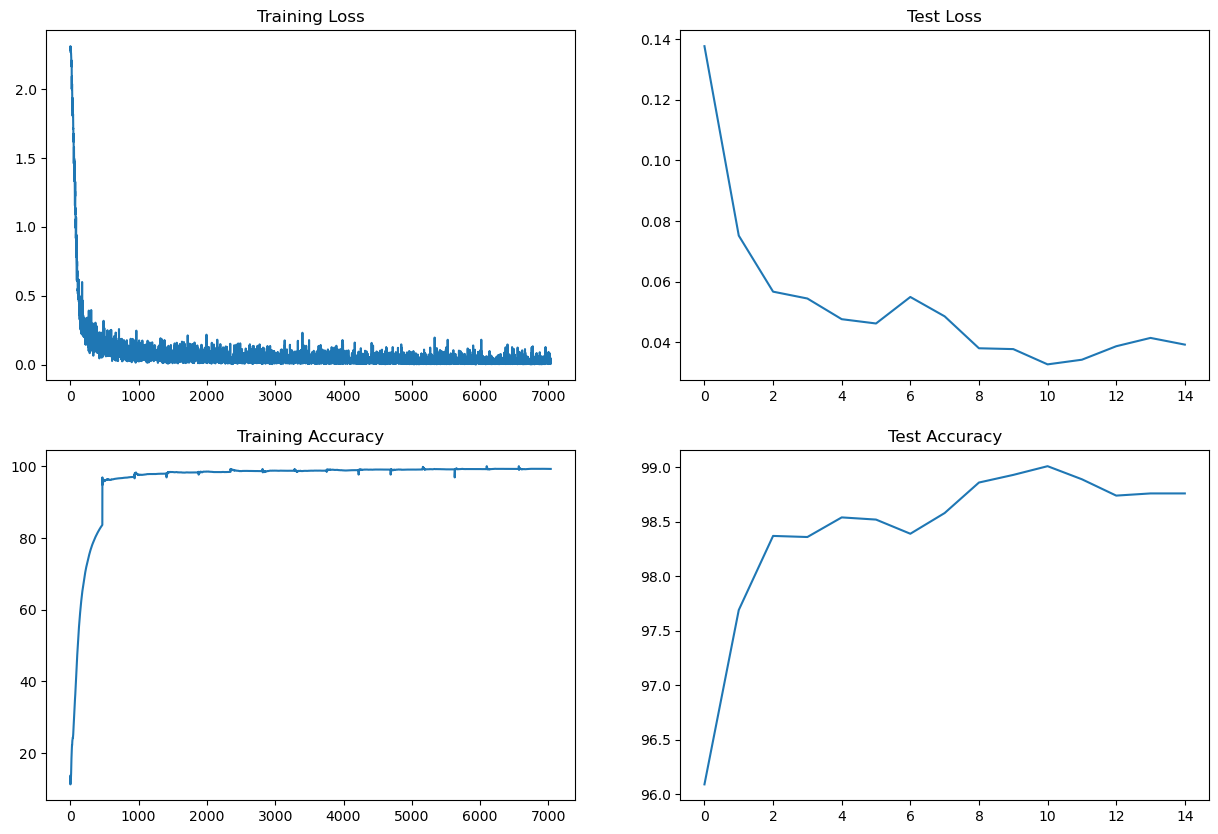

In [13]:
fig, axs = plt.subplots(2,2,figsize=(15, 10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")